In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.optim as optim
from collections import OrderedDict
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
import numpy as np
from time import time
%matplotlib inline

### Setup

In [2]:
# use nvidia gpu if available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# only float32 tested
dtype = torch.float32
    
print("Device:", device)
print("Data type:", dtype)

Device: cpu
Data type: torch.float32


### Define Encoder/Decoder Logic

In [3]:
class L2Norm(nn.Module):
    """L2Norm model class -- a layer class for normalizing a matrix of vectors
    
    Args:
        dim (int) - which dimension to normalize along. 0 for column vectors, 1 for row vectors
    """
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        
        self.dim=dim
        
    def forward(self,input):
        return nn.functional.normalize(input, p=2, dim=self.dim)

In [4]:
class Hamiltonian(nn.Module):
    """Hamiltonian -- a class used to help learn physically relevant sub-manifold
    
    Args:
        H - the hamiltonian matrix in the original basis
        N (int) - the size of the original basis
        N_proj (int) - the size of the projected basis
    """
    
    def __init__(self, H, N, N_proj):

        super(Hamiltonian, self).__init__()
        
        # initialize the class variables
        self.H = H
        self.N = N
        self.N_proj = N_proj
        self.eye = torch.eye(N_proj, device=device, dtype=dtype)
        
        # initialize the encoder and decoder architectures
        self.decoder = nn.Sequential(OrderedDict([('matmul', nn.Linear(self.N_proj, self.N, bias=False)),
                                                  ('normalize', L2Norm())
                                                  ]))

    # return the current cost matrix
    def forward(self):
        M = self.decoder(self.eye)
        return M @ self.H @ M.t(), M @ M.t()

In [5]:
class Cost():
    """Cost class -- used to calculate goodness of projection map for optimization purposes
    
    Args:
        N_proj - number of basis states in the projected space
        alpha (float) - the weight of the orthogonality cost relative to the energy cost (units of energy)
    """
    
    def __init__(self, N_proj, alpha):
        super(Cost, self).__init__()
        
        self.N_proj = N_proj
        self.eye = torch.eye(N_proj, device=device, dtype=dtype)
        self.sorter = torch.tensor([[1/(i+1)/(j+1) for i in range(self.N_proj)] for j in range(self.N_proj)], device=device, dtype=dtype)
        
    def __call__(self, Hproj, Iproj):
        cost_matrix = (Hproj*self.sorter)**2 + alpha * (Iproj - self.eye)**2
        return cost_matrix.sum()/self.N_proj**2

### Synthesize a reasonable test Hamiltonian

In [6]:
def generate_H(N, N_proj):
    H_rand=6*(torch.rand(N,N_proj, device=device, dtype=dtype)-0.5)
    eigs,_ = (torch.rand(N, device=device, dtype=dtype)*N).sort()
    Hgen_proj = torch.diag(eigs)
    Wgen = torch.tensor(ortho_group.rvs(N), device=device, dtype=dtype)
    
    Hgen = Wgen @ Hgen_proj @ Wgen.t()
    
    return Hgen, Wgen, eigs

In [7]:
# Hamiltonian Setup
N=1500
N_proj=30
alpha=1

In [8]:
Hgen, Wgen, eigs = generate_H(N, N_proj)
print ("eigs:", eigs[:N_proj])

eigs: tensor([ 4.2500,  4.7917,  7.6825,  8.0230, 10.1955, 10.5412, 11.0918, 13.0776,
        13.8619, 14.9425, 14.9497, 15.2939, 15.5371, 16.0908, 16.3321, 19.3154,
        20.5846, 20.5997, 20.8394, 23.8374, 24.4785, 24.6685, 25.0423, 25.4188,
        25.7246, 27.6065, 27.7429, 27.9209, 28.8505, 29.7691])


In [9]:
%time torch.symeig(Hgen, eigenvectors=True).eigenvalues[:N_proj]

CPU times: user 1.21 s, sys: 4.37 ms, total: 1.22 s
Wall time: 304 ms


tensor([ 4.2497,  4.7927,  7.6829,  8.0235, 10.1957, 10.5414, 11.0914, 13.0779,
        13.8621, 14.9422, 14.9498, 15.2943, 15.5377, 16.0916, 16.3329, 19.3153,
        20.5850, 20.6000, 20.8398, 23.8377, 24.4785, 24.6682, 25.0420, 25.4194,
        25.7249, 27.6066, 27.7431, 27.9209, 28.8508, 29.7694])

In [10]:
# the hamiltonian model
model = Hamiltonian(Hgen, N, N_proj).to(device=device)

In [11]:
# loss function and optimizer
criterion = Cost(N_proj, alpha)
optimizer = optim.Rprop(model.parameters(), lr=0.1)

### Optimization

In [12]:
def early_stop(errs, rel_tol, patience=2):
    stop=True
    for i in range(patience):
        rel_change = np.abs((errs[-(i+1)] - errs[-(i+2)]) / errs[-(i+1)])
        stop = stop and rel_change < rel_tol
    return stop

def optimize(n_iter, n_save, show_progress=True, stop_early=True, rel_tol=0.01, patience=2):
    model.decoder.matmul.reset_parameters()
    running_loss= 0
    start_time = time()
    
    # store progress every n_save iters
    j=0
    its = []
    errs = []
    Hps = []
    Ips = []
    ts = []
    
    # iterate
    for i in range(n_iter):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        Hp, Ip = model()
        loss = criterion(Hp, Ip)
        loss.backward()
        optimizer.step()

        # print /save statistics
        running_loss += loss.item()
        if i % n_save == 0:
            # save progress
            its.append(i)
            errs.append(running_loss)
            Hps.append(Hp)
            Ips.append(Ip)
            ts.append(time() - start_time)
            
            # print progress 
            if show_progress:
                change = errs[j]-errs[j-1] if j>0 else 0
                print('[%d] loss: %.8f. diff: %.8f. time: %.4f' % (i + 1, running_loss / 10, change, ts[-1]))
            
            if j>=patience and stop_early and early_stop(errs, rel_tol, patience):
                print("Early stopping criteria met.")
                break
            
            running_loss = 0.0
            j+=1

    print('Finished Training')
    return its, errs, Hps, Ips, ts

In [13]:
# Test
n_iter=4000
n_print=200
its, errs, hps, ips, ts = optimize(n_iter, n_print, stop_early=True, rel_tol=0.01, patience=3)

[1] loss: 67.48872070. diff: 0.00000000. time: 0.0110
[201] loss: 53.10179131. diff: -143.86929395. time: 1.1164
[401] loss: 0.67918450. diff: -524.22606806. time: 2.2189
[601] loss: 0.60839865. diff: -0.70785856. time: 3.4093
[801] loss: 0.59075405. diff: -0.17644601. time: 4.5548
[1001] loss: 0.57936205. diff: -0.11391997. time: 5.6609
[1201] loss: 0.56744840. diff: -0.11913651. time: 6.7685
[1401] loss: 0.55009148. diff: -0.17356915. time: 7.8765
[1601] loss: 0.52593473. diff: -0.24156752. time: 8.9773
[1801] loss: 0.50738888. diff: -0.18545854. time: 10.0790
[2001] loss: 0.49694561. diff: -0.10443263. time: 11.1774
[2201] loss: 0.48999907. diff: -0.06946543. time: 12.3050
[2401] loss: 0.48477305. diff: -0.05226025. time: 13.4416
[2601] loss: 0.48063566. diff: -0.04137382. time: 14.5709
[2801] loss: 0.47734654. diff: -0.03289127. time: 15.7352
[3001] loss: 0.47476539. diff: -0.02581148. time: 16.9075
Early stopping criteria met.
Finished Training


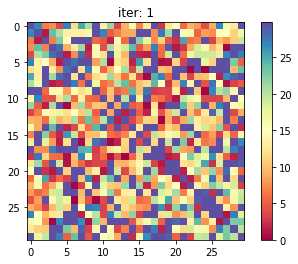

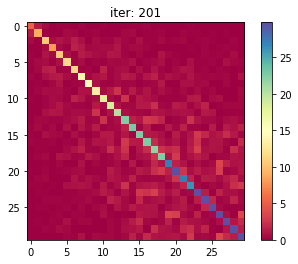

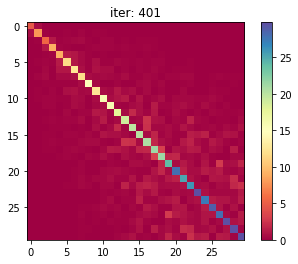

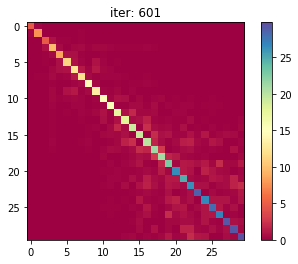

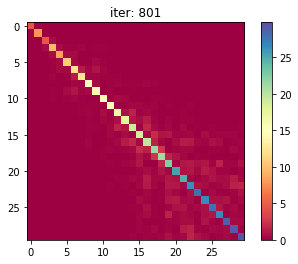

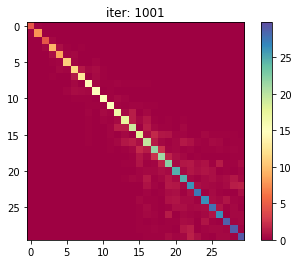

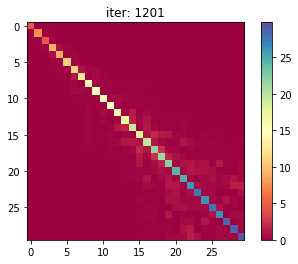

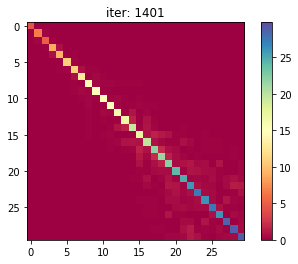

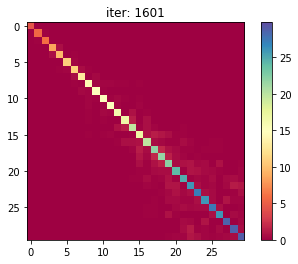

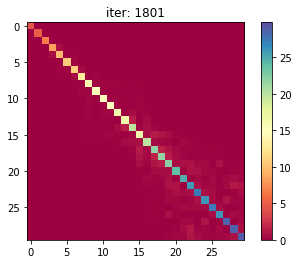

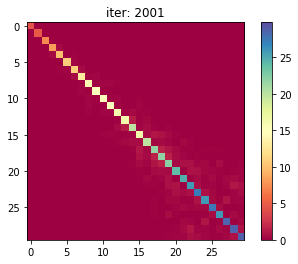

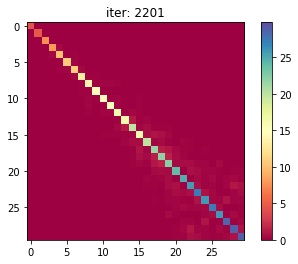

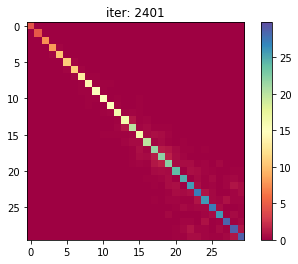

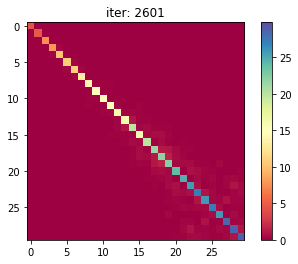

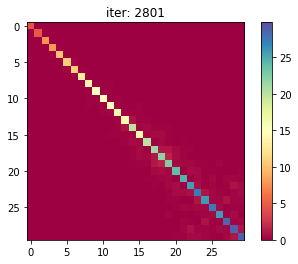

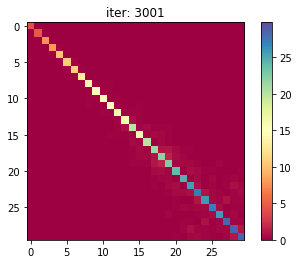

In [14]:
# hproj progress
for it, hp in zip(its,hps):
    vmax=eigs[:N_proj].abs().max()
    vmin=0
    Hplt = hp.cpu().detach().numpy()
    plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)
    plt.title("iter: %i" % (it+1))
    plt.colorbar()
    plt.show()

### Time Complexity Measurements

#### Scaling w/ N

In [19]:
# use cpu for timing due to massive gpu parallelization
device = torch.device('cpu')

In [20]:
Ns = np.logspace(2,3.2,5).astype(int)
N_proj = 10
repeats = 10
lam=1
max_iter = 10000
n_print = 200
criterion = Cost(N_proj, alpha)

In [ ]:
average_time = []
stddev_time = []
for N in Ns:
    t = []
    for r in range(repeats):
        print("N=%i. Nproj=%i. repeat=%i" % (N, N_proj, r+1))
        H, _, _ = generate_H(N, N_proj)
        model = Hamiltonian(H, N, N_proj).to(device=device)
        optimizer = optim.Rprop(model.parameters(), lr=0.1)

        _, _, _, _, ts = optimize(max_iter, n_print, show_progress=False, stop_early=True, rel_tol=0.01, patience=3)

        t.append(ts[-1])
        
    average_time.append(np.average(t))
    stddev_time.append(np.std(t))

N=100. Nproj=10. repeat=1
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=2
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=3
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=4
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=5
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=6
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=7
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=8
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=9
Early stopping criteria met.
Finished Training
N=100. Nproj=10. repeat=10
Early stopping criteria met.
Finished Training
N=199. Nproj=10. repeat=1
Early stopping criteria met.
Finished Training
N=199. Nproj=10. repeat=2
Early stopping criteria met.
Finished Training
N=199. Nproj=10. repeat=3
Early stopping criteria met.
Finished Training
N=199. Nproj=10. repeat=4
Early stopping criteria 

In [ ]:
plt.loglog(Ns, average_time, 'bo-')
plt.grid()

In [ ]:
np.polyfit(np.log(Ns), np.log(average_time), 1)

$t \sim \mathcal{O}\left(N^{0.83}\right) $